# Forward modelling gravity data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import discretize
import simpeg
from simpeg import potential_fields

## Build synthetic mesh

In [2]:
hx = [(100.0, 128)]
hz = [(50.0, 128)]
mesh = discretize.TreeMesh(h=[hx, hx, hz], origin="CCN")

mesh.refine_box(x0s=(-3e3, -3e3, -3e3), x1s=(3e3, 3e3, 0), levels=3, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-2e3, -2e3, -2e3), x1s=(2e3, 2e3, 0), levels=6, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-2e3, -2e3, -1e3), x1s=(2e3, 2e3, 0), levels=7, finalize=False, diagonal_balance=True)
mesh.refine_box(x0s=(-2e3, -2e3, -500), x1s=(2e3, 2e3, 0), levels=-1, finalize=False, diagonal_balance=True)

mesh.finalize()
mesh

OcTreeMesh: 2.50% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  2   :       16             ---------------------------   --------------------
  3   :       240         x:    -6400.0   ,   6400.0         100.0   ,   3200.0  
  4   :       768         y:    -6400.0   ,   6400.0         100.0   ,   3200.0  
  5   :      1488         z:    -6400.0   ,     0.0           50.0   ,   1600.0  
  6   :      7348      
  7   :      42592     
-----------------------
Total :      52452

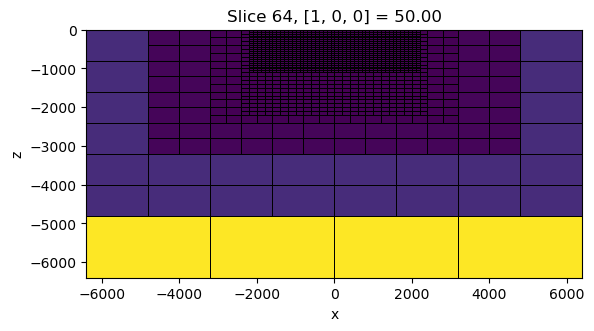

In [3]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes, normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.show()

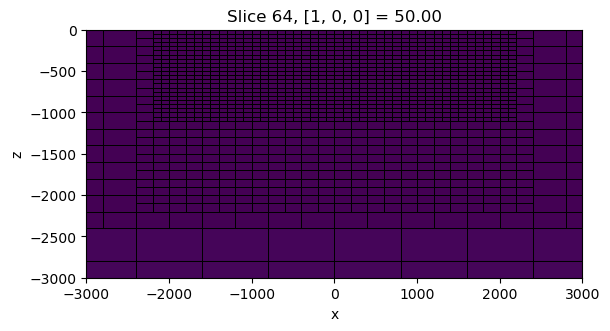

In [4]:
grid_opts = {"linewidth": 0.5, "color": "k"}

mesh.plot_slice(mesh.cell_volumes, normal="x", grid=True, grid_opts=grid_opts)
plt.gca().set_aspect("equal")
plt.xlim(-3e3, 3e3)
plt.ylim(-3e3, 0)
plt.show()

In [5]:
block = (-300, 300, -300, 300, -800, -500)

model = np.zeros(mesh.n_cells)
model = simpeg.utils.model_builder.add_block(
    mesh.cell_centers,
    model,
    p0=np.array(block[::2]),
    p1=np.array(block[1::2]),
    prop_value=0.2,
)

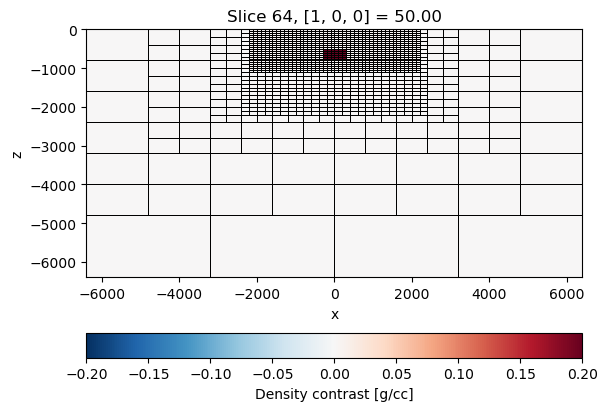

In [6]:
grid_opts = {"linewidth": 0.5, "color": "k"}

maxabs = np.max(np.abs(model))
                
tmp, = mesh.plot_slice(
    model,
    normal="x",
    grid=True,
    grid_opts=grid_opts,
    clim=(-maxabs, maxabs),
    pcolor_opts=dict(cmap="RdBu_r"),
)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, orientation="horizontal", label="Density contrast [g/cc]")
plt.show()

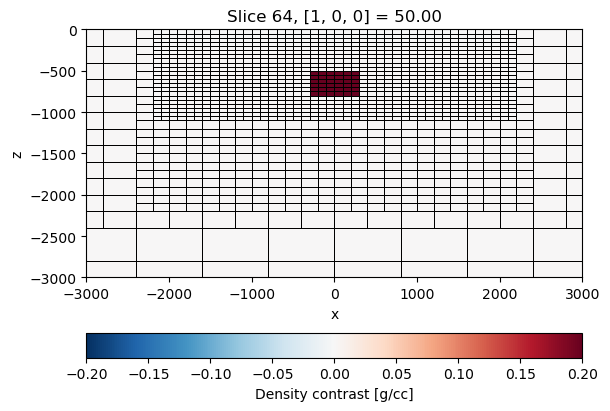

In [7]:
grid_opts = {"linewidth": 0.5, "color": "k"}

maxabs = np.max(np.abs(model))
                
tmp, = mesh.plot_slice(
    model,
    normal="x",
    grid=True,
    grid_opts=grid_opts,
    clim=(-maxabs, maxabs),
    pcolor_opts=dict(cmap="RdBu_r"),
)

# Plot outlines of the block
plot_block = False
if plot_block:
    from matplotlib.patches import Rectangle
    rectangle = Rectangle(
        xy=(block[0], block[4]),
        width=block[1] - block[0],
        height=block[5] - block[4],
        facecolor="none",
        edgecolor="C2",
        linewidth=2,
    )
    plt.gca().add_patch(rectangle)
    
plt.gca().set_aspect("equal")
plt.colorbar(tmp, orientation="horizontal", label="Density contrast [g/cc]")
plt.xlim(-3e3, 3e3)
plt.ylim(-3e3, 0)
plt.show()

## Forward modelling

In [8]:
region = (-2e3, 2e3, -2e3, 2e3)
spacing = (100, 100)
height = 10.0

shape = (
    int((region[1] - region[0]) / spacing[1]) + 1,
    int((region[3] - region[2]) / spacing[0]) + 1,
)

easting = np.linspace(*region[:2], shape[1])
northing = np.linspace(*region[2:], shape[0])
easting, northing = np.meshgrid(easting, northing)
upward = height * np.ones_like(easting)

print(shape)

(41, 41)


In [9]:
receiver_locations = np.vstack(
    tuple(c.ravel() for c in (easting, northing, upward))
).T
receiver_locations.shape

(1681, 3)

In [10]:
receivers = potential_fields.gravity.Point(
    receiver_locations,
    components="gz",
)

source = potential_fields.gravity.SourceField(
    receiver_list=[receivers],
)

survey = potential_fields.gravity.Survey(source)

In [11]:
mapping = simpeg.maps.IdentityMap(mesh)
simulation = potential_fields.gravity.Simulation3DIntegral(
    mesh=mesh,
    survey=survey,
    rhoMap=mapping,
    engine="choclo",
)

In [12]:
gz = simulation.dpred(model)
gz

array([-0.00392693, -0.00421797, -0.00452889, ..., -0.00452889,
       -0.00421797, -0.00392693], dtype=float32)

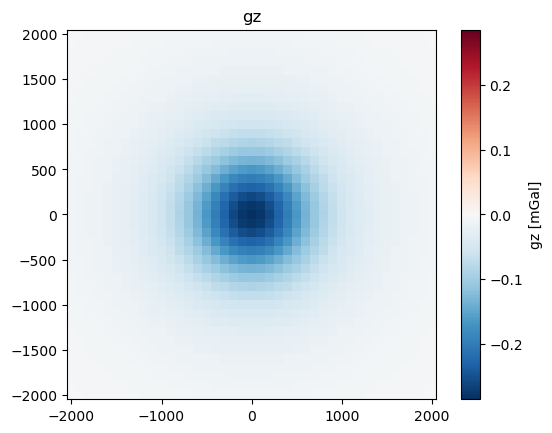

In [13]:
maxabs = np.max(np.abs(gz))

plt.pcolormesh(
    easting,
    northing,
    gz.reshape(easting.shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz [mGal]")
plt.title("gz")
plt.show()

Add gaussian noise to the synthetic data

In [14]:
percentage = 1/100
rng = np.random.default_rng(42)

std = percentage * np.max(np.abs(gz))
gz += rng.normal(loc=0, scale=std, size=gz.size)

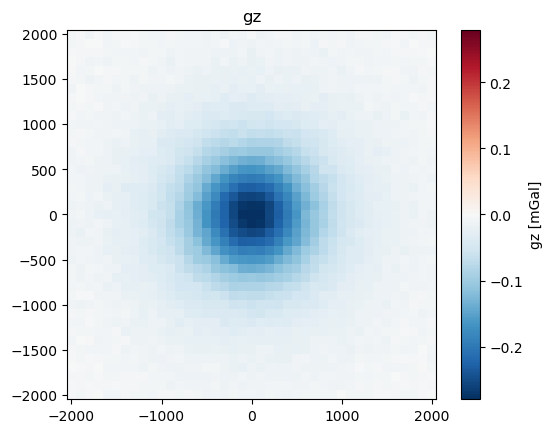

In [15]:
maxabs = np.max(np.abs(gz))

plt.pcolormesh(
    easting,
    northing,
    gz.reshape(easting.shape),
    cmap="RdBu_r",
    vmin=-maxabs,
    vmax=maxabs
)
plt.gca().set_aspect("equal")
plt.colorbar(label="gz [mGal]")
plt.title("gz")
plt.show()

## Save data in file

In [16]:
easting, northing, upward = tuple(
    receivers.locations[:, i] for i in range(3)
)
gz_std = np.ones_like(gz) * std

df = pd.DataFrame(
    dict(
        easting=easting,
        northing=northing,
        upward=upward,
        gz=gz,
        gz_std=gz_std,
    )
)
df

,easting,northing,upward,gz,gz_std
0,-2000.0,-2000.0,10.0,-0.003058,0.002853
1,-1900.0,-2000.0,10.0,-0.007185,0.002853
2,-1800.0,-2000.0,10.0,-0.002388,0.002853
3,-1700.0,-2000.0,10.0,-0.002177,0.002853
4,-1600.0,-2000.0,10.0,-0.010777,0.002853
...,...,...,...,...,...
1676,1600.0,2000.0,10.0,-0.002390,0.002853
1677,1700.0,2000.0,10.0,-0.003820,0.002853
1678,1800.0,2000.0,10.0,-0.006600,0.002853
1679,1900.0,2000.0,10.0,-0.005018,0.002853


In [17]:
df.to_csv("gravity.csv", index=None)